# Mobile App Store (7200 apps) 

**Data source:**https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps

App user ratings plays an important role in app revenue. 

If your app has low ratings, its search position tends to be low. The top 10 rated apps gather 90% of category revenue, all the rest compete for the remaining 10 percent.


*With data extracted from the itunes data from Kaggle, this project explores the non-language and language features that predict app user ratings.*


**Project Focus:**
- Feature engineering
- EDA and visualisation


In [81]:
import pandas as pd
import re
import numpy as np

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
from hurry.filesize import size

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
import sys
pd.options.display.encoding = sys.stdout.encoding

In [86]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, RFECV

# EDA

In [180]:
df = pd.read_csv('AppleStore.csv', index_col=[0]).reset_index(drop=True)

In [181]:
description = pd.read_csv('appleStore_description.csv')

In [182]:
df = pd.merge(df, description.app_desc, left_index=True, right_index=True)

In [183]:
print(list(df.columns))

['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic', 'app_desc']


In [184]:
df.head()

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc
0,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,On more than 250 million devices around the wo...


In [185]:
df.shape

(7197, 17)

In [186]:
print('There are {} duplicates found in this data'.format(df.duplicated().sum()))
print('There are {} nulls found in this data'.format(df.isnull().sum().sum()))

There are 0 duplicates found in this data
There are 0 nulls found in this data


#### Convert bytes into a more readable format of megabytes 

In [187]:
df['mega_bytes'] = df.size_bytes.apply(lambda x: size(x)\
                            .replace('M', ''))\
                            .apply(lambda x: (x.replace('G', '000')) if 'G' in x else x)\
                            .apply(lambda x: (int((x.replace('K', '')))/1000) if 'K' in x else x)\
                            .astype(float)
                            

In [188]:
df.drop('size_bytes', axis=1, inplace=True)

**Increasing memory (MB) will increase the user ratings. This effect becomes less obvious in ratings 4.5 and above**

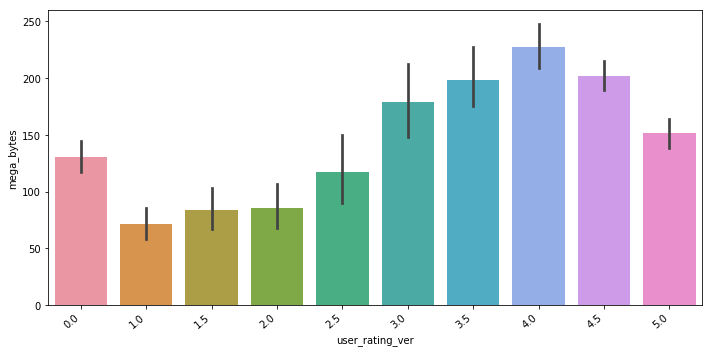

In [189]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=df.user_rating_ver, y=df.mega_bytes)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**Medical, Game and Education apps have largest average sizes (MB)**

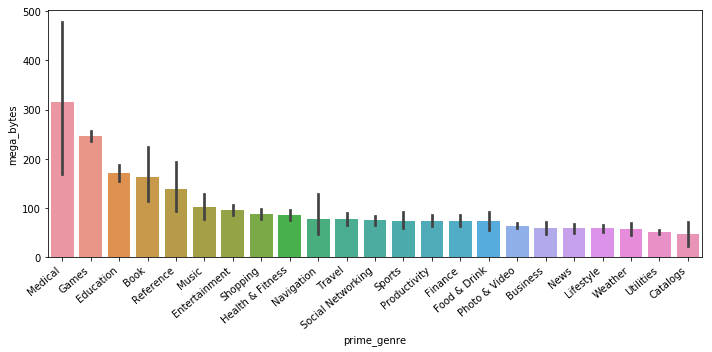

In [190]:
temp = df.groupby('prime_genre')[['mega_bytes']].aggregate(np.mean).reset_index().sort_values('mega_bytes', ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=df.prime_genre, y=df.mega_bytes, order=temp['prime_genre'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### Price distribution 

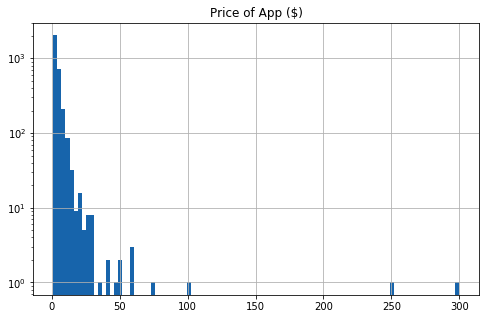

In [191]:
fig, ax = plt.subplots(figsize = (8,5))
df[df['price']>0].price.hist(bins = 100, ax = ax);
ax.set_yscale("log")
ax.set_title("Price of App ($)")
plt.show()

Here, we can see a number of outliers. I may consider removing them later on during modelling. ($30 and above).

In [192]:
temp = df[df['price'] <= 30]

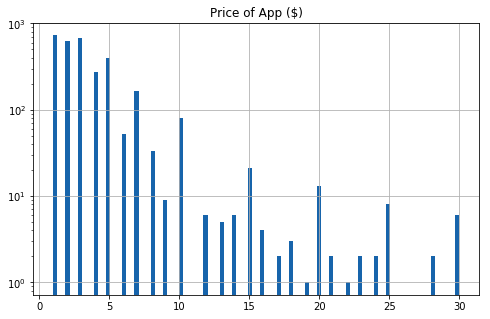

In [193]:
#what the distribution would look like if outliers were removed. 
fig, ax = plt.subplots(figsize = (8,5))
temp[temp['price']>0].price.hist(bins = 100, ax = ax);
ax.set_yscale("log")
ax.set_title("Price of App ($)")
plt.show()

In [194]:
print('{} of the total {} are free apps'.format(df[df['price'] == 0].shape[0],df.shape[0]))

4056 of the total 7197 are free apps


Extract whether the app is free or not

In [195]:
df['free_app'] = df.price.apply(lambda x: 1 if x == 0 else 0)

**The free apps are more likely to have higher user ratings**

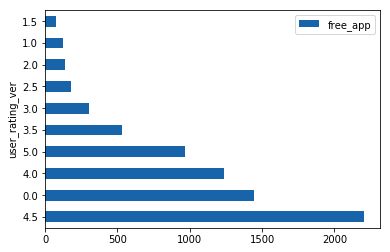

In [196]:
df.groupby('user_rating_ver')[['free_app']].count().sort_values(by='free_app', ascending=False).plot(kind='barh');

#### Rating counts for all and current versions

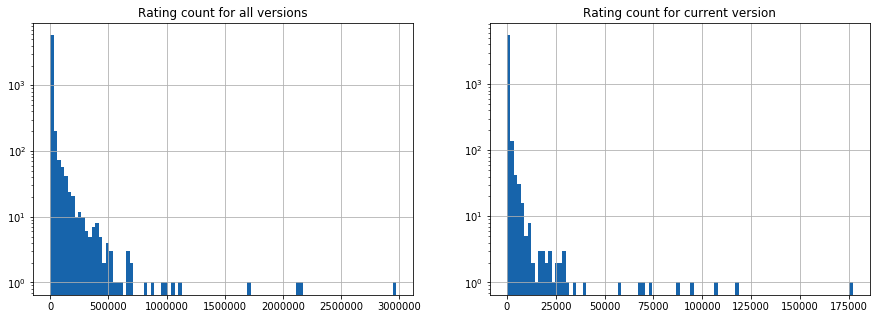

In [197]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
df[df['rating_count_tot']>0].rating_count_tot.hist(bins = 100, ax = ax[0]);
df[df['rating_count_ver']>0].rating_count_ver.hist(bins = 100, ax = ax[1]);

ax[0].set_yscale("log")
ax[1].set_yscale("log")


ax[0].set_title("Rating count for all versions")
ax[1].set_title("Rating count for current version")
plt.show()

#### Avg ratings for all and current versions 

**Avg ratings grow exponentially in size until 4.5** 

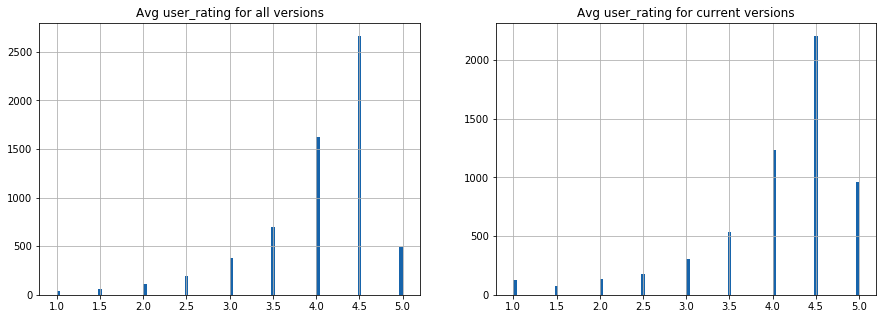

In [198]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
df[df['user_rating']>0].user_rating.hist(bins = 100, ax = ax[0]);
df[df['user_rating_ver']>0].user_rating_ver.hist(bins = 100, ax = ax[1]);

ax[0].set_title("Avg user_rating for all versions")
ax[1].set_title("Avg user_rating for current versions")
plt.show()

In [199]:
print('There are {} cases where NO ratings were made accross any app version'
      .format(df[(df['rating_count_tot'] == 0) & (df['user_rating'] == 0)].shape[0]))

There are 929 cases where NO ratings were made accross any app version


**In the instances of 0 ratings accross different app versions:**

- This could be due to the poor quality of the app, no rating feature or they were foreign; the API may not have picked up their ratings. 

#### App Version

Drop all non-digits 

In [200]:
df.ver = df.ver.apply(lambda x: re.sub('[^0-9.]', '', str(x)))

Most common versions have a 1 as their major component (first digit)

In [201]:
df.ver.value_counts().head()

1.0      317
1.1      267
1.2      218
1.0.0    187
1.0.1    180
Name: ver, dtype: int64

**1.5.5 version is most expensive on avg**

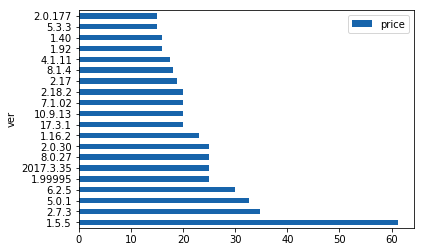

In [202]:
df.groupby('ver')[['price']].mean().sort_values(by='price', ascending=False).head(20).plot(kind='barh');

#### Content Age rating 

Rename for clearer age buckets

In [203]:
df['cont_rating'] = df['cont_rating']\
                    .apply({'4+':'4-8', '9+':'9-11', '12+': '12-16', '17+': '17+'}.get)

Most app ratings appear to be made for the lowest age range (4-8 years)

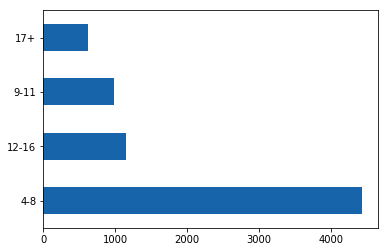

In [204]:
df['cont_rating'].value_counts().plot(kind='barh');

**Avg user ratings and price are highest in the 9-11 age group**

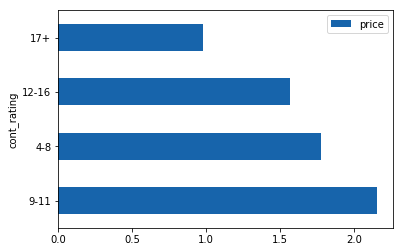

In [205]:
df.groupby('cont_rating')[['price']].mean().sort_values(by=['price'], ascending=False).plot(kind='barh');

**Avg user ratings have the largest spread in 17+ age group - This is interesting; it suggests that an older age group are likely to leave a larger range of reviews than younger age groups.**

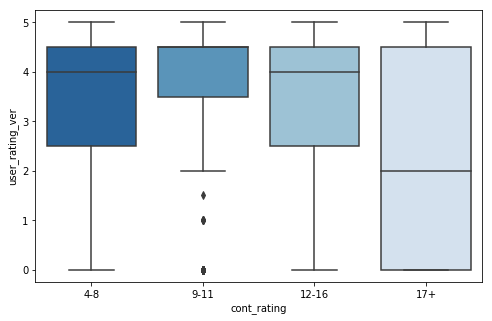

In [207]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x=df.cont_rating, y=df.user_rating_ver, order=['4-8','9-11','12-16', '17+']);

#### Prime genre

In [208]:
df.prime_genre.value_counts().head()

Games            3862
Entertainment     535
Education         453
Photo & Video     349
Utilities         248
Name: prime_genre, dtype: int64

**Music, productivity, game and photo apps have highest ratings and finance having lowest**

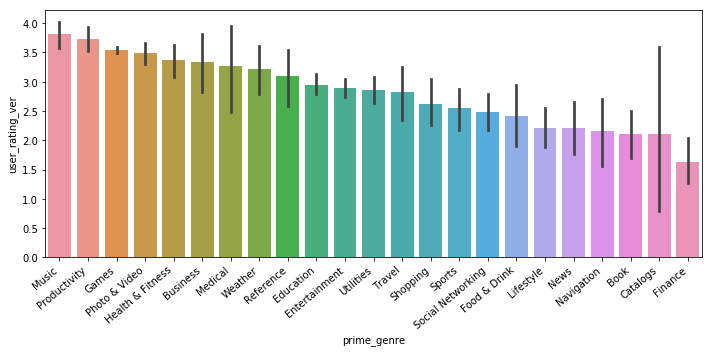

In [209]:
temp = df.groupby(["prime_genre"])['user_rating_ver'].aggregate(np.mean).reset_index().sort_values('user_rating_ver', ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=df.prime_genre, y=df.user_rating_ver, order=temp['prime_genre'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**Medical apps are most expensive and shopping is the least**

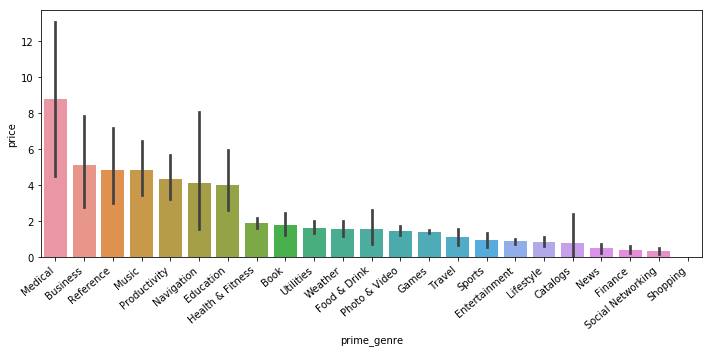

In [210]:
temp = df.groupby(["prime_genre"])['price'].aggregate(np.mean).reset_index().sort_values('price', ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=df.prime_genre, y=df.price, order=temp['prime_genre'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**How price distribution gets effected by category**

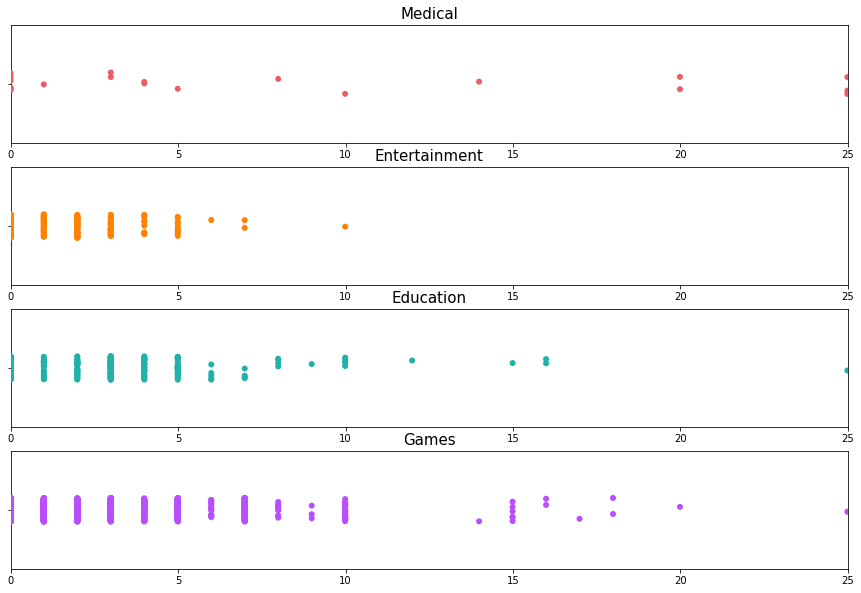

In [274]:
yrange = [0,25]
fsize =15

plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.xlim(yrange)
medical = df[df.prime_genre=='Medical']
sns.stripplot(data=medical,y='price',jitter= True , orient ='h',size=6,color='#eb5e66')
plt.title('Medical',fontsize=fsize)
plt.xlabel('') 

plt.subplot(4,1,2)
plt.xlim(yrange)
ent = df[df.prime_genre=='Entertainment']
sns.stripplot(data=ent,y='price',jitter= True ,orient ='h',size=6,color='#ff8300')
plt.title('Entertainment',fontsize=fsize)
plt.xlabel('') 

plt.subplot(4,1,3)
plt.xlim(yrange)
edu = df[df.prime_genre=='Education']
sns.stripplot(data=edu,y='price',jitter= True ,orient ='h' ,size=6,color='#20B2AA')
plt.title('Education',fontsize=fsize)
plt.xlabel('') 

plt.subplot(4,1,4)
plt.xlim(yrange)
games = df[df.prime_genre=='Games']
sns.stripplot(data=games,y='price',jitter= True  ,orient ='h',size=6,color='#b84efd')
plt.title('Games',fontsize=fsize)
plt.xlabel('') 

plt.show()

#### Supporting devices 

In [211]:
df['sup_devices.num'].value_counts().head()

37    3263
38    1912
40    1142
43     371
24     270
Name: sup_devices.num, dtype: int64

**Not any obvious patterns found between the number of supporting devices and Ratings, Price and Memory**

#### Screenshots on display 

**Most apps have either 5 screenshots or 0**

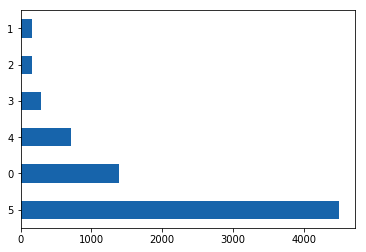

In [212]:
df['ipadSc_urls.num'].value_counts().plot(kind='barh');

**Apps with more screenshots have higher user ratings, suggesting that display of app is important. Research suggests this this is a critical factor**

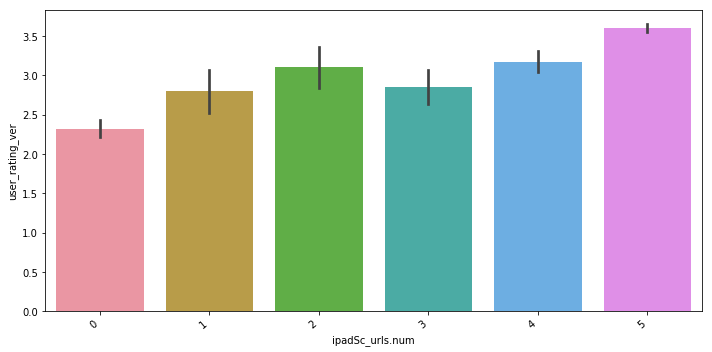

In [213]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=df['ipadSc_urls.num'], y=df.user_rating_ver)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### Number of supported languages

**Majority of apps (3767) in this dataset are only supported by one language**

In [214]:
df['lang.num'].value_counts().head()

1     3767
2      675
11     266
3      217
5      207
Name: lang.num, dtype: int64

**Number of supporting languages did not seem to have much of an effect on price or memory. However, increasing the number of supporting languages did increase the user ratings - *Roughly 5 languages is reccomended***

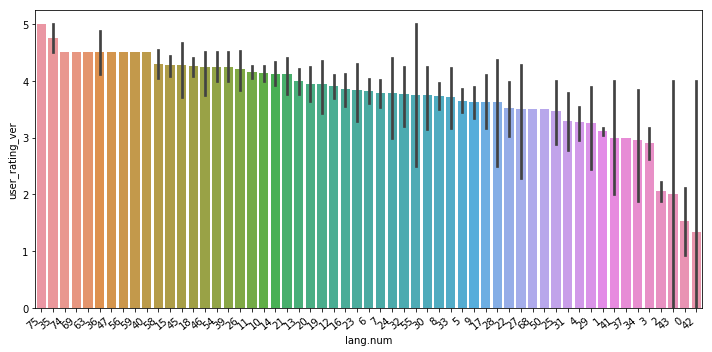

In [215]:
temp = df.groupby(["lang.num"])['user_rating_ver'].aggregate(np.mean).reset_index().sort_values('user_rating_ver', ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=df['lang.num'], y=df.user_rating_ver, order=temp['lang.num'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### Vpp Device Based Licensing Enabled variable

The Volume Purchase Program (VPP) binary variable: Apple portal for businesses and schools to purchase and license apps and books in volume.

Majority of apps hold this license (50 do not) 

In [216]:
df['vpp_lic'].value_counts()

1    7147
0      50
Name: vpp_lic, dtype: int64

**The apps that do not hold this license:**
- Have lower user ratings, are more expensive and hold more memory.
- Majority are foreign catalogs apps

In [217]:
df.groupby('prime_genre')[['vpp_lic']].count().sort_values(by='vpp_lic', ascending=True).head()

,vpp_lic
prime_genre,
Catalogs,10
Medical,23
Navigation,46
Business,57
Food & Drink,63


In [218]:
df[df['vpp_lic'] == 0].tail(1)

,id,track_name,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,mega_bytes,free_app
7164,1181724803,ＣＲスーパー海物語ＩＮ沖縄４,USD,9.99,0,0,0.0,0.0,1.0.2,12-16,Games,40,0,1,0,【「海モード・マリンモード」が遊べる追加パック対応！】\n\n【説明】\n■対応機種\niP...,3000.0,0


# Feature engineering

- Drop redundant columns
- Subset English apps 
- Extract version features 
- Engineer language based features (length, special lettering and capitals) from app name
- Engineer language based features from description 

**Main caveats:** 
- Foreign apps 
- Messy column names 

Drop ID and currency as they are redundant and offer not additional information

In [219]:
df.drop(['id', 'currency'], axis=1, inplace=True)

I want to first clean up track name column; I want to filter out additional information and prioritise just the name

In [220]:
df['app_name'] = df.track_name\
                    .str.split(' – ').str[0]\
                    .str.split(' - ').str[0]\
                    .str.split(' -').str[0]\
                    .str.split(': ').str[0]

For now I will ignore the rest of the title

In [221]:
df.drop('track_name', axis=1, inplace=True)

Now I want to return a feature exploring whether the app has non-english characters

In [222]:
def cjk_detect(texts):
    # korean
    if re.search("[\uac00-\ud7a3]", texts):
        return "ko"
    # japanese
    if re.search("[\u3040-\u30ff]", texts):
        return "ja"
    # chinese
    if re.search("[\u4e00-\u9FFF]", texts):
        return "zh"
    return 'English characters'

In [223]:
df['foreign_char'] = df['app_name'].apply(lambda x: cjk_detect(x))
df.foreign_char.value_counts()

English characters    6172
ja                     549
zh                     474
ko                       2
Name: foreign_char, dtype: int64

For now I will subset all the apps with english characters 

In [224]:
df = df[df['foreign_char'] == 'English characters']

In [225]:
df.drop('foreign_char', axis=1, inplace=True)

In [226]:
df.shape 

(6172, 16)

App versions have 3 main components: major, minor and patch. I am going to focus on major component, which moniters major changes, like rewriting of an app. 

In [227]:
df['major_ver'] = df.ver.apply(lambda x: str(x).split('.')[0]).astype(int)\
                    .apply(lambda x: 1 if x == 9999 else x)\
                    .apply(lambda x: 4 if x== 2013 else x)\
                    .apply(lambda x: np.nan if x> 120 else x)

print("There are {} apps that have version numbers that are in an unusual format,\
 with a major version component larger\
   than 120.".format(df.major_ver.isnull().sum()))

There are 10 apps that have version numbers that are in an unusual format, with a major version component larger   than 120.


Impute these 10 remaining apps that have unusual format

In [228]:
df['major_ver'] = df['major_ver'].fillna(df.major_ver.median())

Do apps with earlier/later versions (lower/higher major components), have higher ratings?

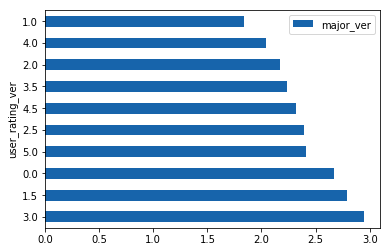

In [229]:
df.groupby('user_rating_ver')[['major_ver']].mean().sort_values(by='major_ver', ascending=False).plot(kind='barh');

I would like to return the number of dots in the version. This may give an indication to how many changes and how much engineering has gone into the app.

In [230]:
df['length_ver'] = df.ver.apply(lambda x: len(str(x).split('.')))
df.length_ver.value_counts()

3    3605
2    2514
1      29
4      23
5       1
Name: length_ver, dtype: int64

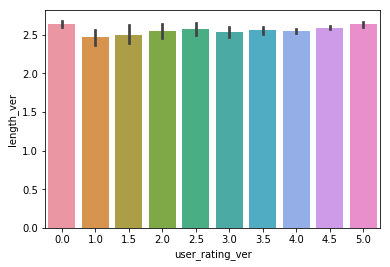

In [231]:
sns.barplot(x = df.user_rating_ver, y=df.length_ver);

In [232]:
df.drop('ver', axis=1, inplace=True)

Get the length name of the app

In [233]:
df['app_name_len'] = df.app_name.apply(lambda x: len(re.sub("[^0-9A-Za-z]", "", x)) if str(x)==x else 0)

**Research suggests that the shorter the length of the name, the more successful**

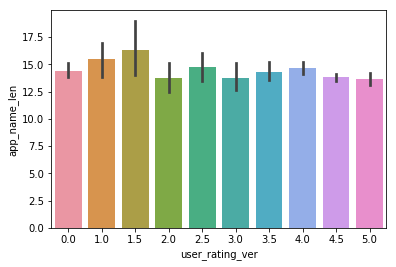

In [234]:
sns.barplot(x = df.user_rating_ver, y=df.app_name_len);

Sticky letter count - memorable characters in a name

In [235]:
df['sticky_letter_count'] = df.app_name.\
                                apply(lambda x: (len(re.sub("[^kKyYzZxX]", "", x))) if str(x)==x else 0).\
                                apply(lambda x: 1 if x>0 else 0)

Research suggests that ratings are better in apps that have sticky letters

In [236]:
df.groupby('sticky_letter_count')[['user_rating_ver']].mean()

,user_rating_ver
sticky_letter_count,
0,3.620568
1,3.690286


Return if word starts with a capital letter

In [237]:
def is_capital(cell):
    if cell[0].isupper():
        return 1
    elif cell[1].isupper():
        return 1
    elif cell[0] == ':':
        return 1
    else:
        return 0 

In [238]:
df['first_letter_capital'] = df.app_name.apply(lambda x: is_capital(x))
df['first_letter_capital'].value_counts()

1    6021
0     151
Name: first_letter_capital, dtype: int64

**Research suggests that ratings are better in apps that have have a capital letter at the start**

In [239]:
df.groupby('user_rating_ver')[['first_letter_capital']].count().sort_values(by='first_letter_capital').head()

,first_letter_capital
user_rating_ver,
1.5,72
1.0,99
2.0,126
2.5,172
3.0,284


Return the count of syllabels

In [240]:
def syllable_count(word):
    try:
        word = word.lower()
        count = 0
        vowels = "aeiouy"
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                count += 1
        if word.endswith("e"):
            count -= 1
        if count == 0:
            count += 1
        return count
    except:
        return 0

In [241]:
df['syllable_count'] = df.app_name.apply(lambda x: syllable_count(re.sub("[^A-Za-z]", "", x)) if str(x)==x else 0)

**Research suggests that the ideal number of syllabals in a name is 1-3**

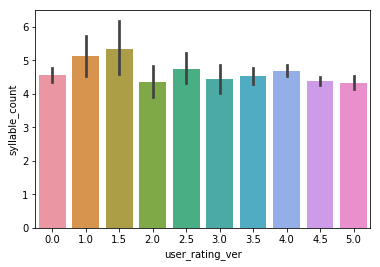

In [242]:
sns.barplot(x = df.user_rating_ver, y=df.syllable_count);

Will drop app name for now

In [150]:
df.drop('app_name', axis=1, inplace=True)

**Will now focus on the app description and its language features**

- The description length
- Contains capital words
- Whether a URL is included
- References to discounts in their description
- Apps awards and achievements

In [243]:
#removing newline characters
df.app_desc = df.app_desc.replace('\n', ' ', regex=True)

In [244]:
#removing foreign descriptions 
df['foreign_char'] = df['app_desc'].apply(lambda x: cjk_detect(x))
df.foreign_char.value_counts()

English characters    6029
ja                      98
zh                      24
ko                      21
Name: foreign_char, dtype: int64

In [245]:
df = df[df['foreign_char'] == 'English characters']

In [246]:
df.drop('foreign_char', axis=1, inplace=True)

In [247]:
df.shape

(6029, 21)

Return description length

In [248]:
df['desc_len'] = df.app_desc.apply(lambda x: len(re.sub("[^0-9A-Za-z]", "", x)) if str(x)==x else 0)

**More lengthy descriptions are linked with higher rated apps**

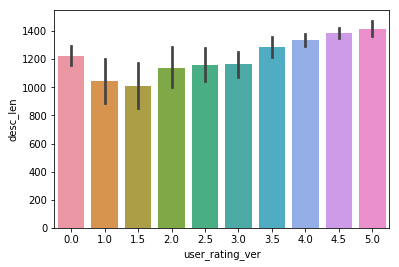

In [249]:
sns.barplot(x = df.user_rating_ver, y=df.desc_len);

Return uppercase ratio of words in description

In [250]:
def uppercase_ratio(cell):
    try:  
        return len(re.findall('[A-Z]', cell))/len(re.findall('[A-Za-z]', cell))
    except:
        pass

In [251]:
df['desc_uppercaseratio'] = df.app_desc.apply(lambda x: uppercase_ratio(x))

**Descriptions with higher ratio of uppercase words may be taken less seriously by users and be deemed as less professional**

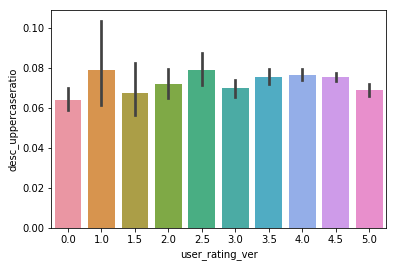

In [252]:
sns.barplot(x = df.user_rating_ver, y=df.desc_uppercaseratio);

Return whether external URL is included 

In [253]:
def URLS(cell):
    return re.findall('(www.[a-zA-Z]*.com/[a-zA-Z]*)', cell)

In [254]:
df['desc_URL'] = df.app_desc\
                .apply(lambda x: URLS(x)).astype(str)\
                .apply(lambda x: 0 if x == '[]' else 1)

In [255]:
df['desc_URL'].value_counts()

0    4641
1    1388
Name: desc_URL, dtype: int64

**The higher rated apps seem to contain external URLs**

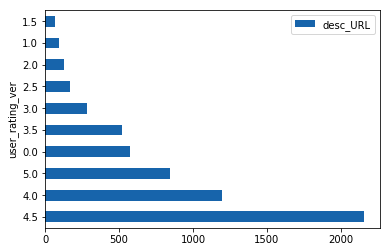

In [256]:
df.groupby('user_rating_ver')[['desc_URL']].count().sort_values(by='desc_URL', ascending=False).plot(kind='barh');

Finding reference to free or discounted deals

In [257]:
deal_terms = ['deal', 'save', 'deals', 'discount', 'free', 'percent', '%', 'limited time', 'saving']

In [258]:
def check_for_deals(string):
    strings = re.sub("[^a-z]", ' ',string.lower()).split()
    count = 0
    for i in strings:
        if i in deal_terms:
            count +=1
    return count

In [259]:
df['desc_deals'] = df.app_desc.apply(lambda x: check_for_deals(x))
df['desc_deals'].value_counts().head()

0    3206
1    1485
2     661
3     344
4     148
Name: desc_deals, dtype: int64

**Apps with reference to free in their description have higher ratings**

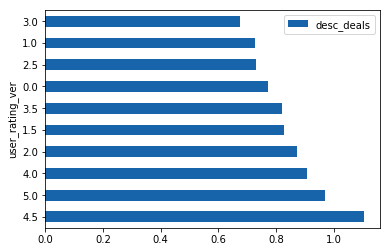

In [260]:
df.groupby('user_rating_ver')[['desc_deals']].mean().sort_values(by='desc_deals', ascending=False).plot(kind='barh');

Finding reference to achievements and awards in the description

In [261]:
award_terms = ['award', 'awards', 'achieve', 'winner', 'win', 'competition', 'achievement', 'achievements', 'prize']

In [262]:
def check_for_awards(string):
    strings = re.sub("[^a-z]", ' ',string.lower()).split()
    count = 0
    for i in strings:
        if i in award_terms:
            count +=1
    return count

In [263]:
df['desc_awards'] = df.app_desc.apply(lambda x: check_for_awards(x))
df['desc_awards'].value_counts().head()

0    4330
1    1010
2     365
3     149
4      75
Name: desc_awards, dtype: int64

**Apps with reference to awards in their description have higher ratings**

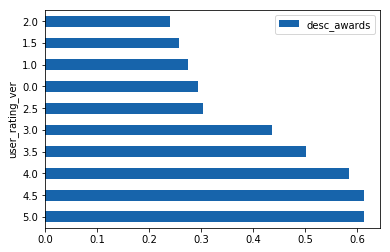

In [264]:
df.groupby('user_rating_ver')[['desc_awards']].mean().sort_values(by='desc_awards', ascending=False).plot(kind='barh');

In [265]:
df.drop('app_desc', axis=1, inplace=True)

In [179]:
df = df.to_csv('engineered_df.csv')

**Future directions:** I am aware there there is lots more to do in reference to language:

- Look at what topic/sentiment best predicts different catagories of apps (Maybe look at the most dominating catagory) 

# Store and prepare dataset 

In [177]:
df = pd.read_csv('engineered_df', index_col=[0]).reset_index(drop=True)

In [9]:
objects = ['prime_genre', 'cont_rating']

df = pd.concat([df.drop(objects, axis = 1),
                pd.get_dummies(df[objects].astype(str), drop_first=True)],
                axis = 1, sort = True)

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(6028, 47)

# Modelling

When information pertaining to previous user rating counts are included as features, the optimum accuracy score achieved is 70 percent (with a Gradboost). 

However, given the nature of this project, I have removed these and focused on the display and language features 

In [12]:
y = df[['user_rating_ver']]
X = df.drop(['user_rating_ver','user_rating', 
             'rating_count_ver', 'rating_count_tot'], axis=1)

Having performed a regression, which performed poorly, I then set this as a binary classfication problem.

In this case, an app which has a user rating larger than 4 is considered 'successful'.

In [13]:
def prepare_data(X,y): 
    
    y_binary = pd.qcut(y, 2, labels=[0,1])
    
    scaler = StandardScaler()
    Xs = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index=X.index)
    X_train, X_test, y_train, y_test = train_test_split(Xs, y_binary, 
                                                        test_size=0.2, 
                                                        random_state=1, 
                                                        stratify=y, 
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepare_data(X,y['user_rating_ver'])

In [15]:
print('The baseline: {}'.format(round(y_test.value_counts(normalize=True).max(),3)))

The baseline: 0.502


### Classification 

Ran a number of different classification models 

In [17]:
def scoring_algos(model, x_train, y_train):
    fitted_model = model.fit(x_train, y_train)
    return cross_val_score(fitted_model, X_train, y_train, cv = 5, n_jobs = 2).mean()

models = {
    'K-nearest': KNeighborsClassifier(),
    'Logistic': LogisticRegression(random_state = 1),
    'Random-forest': RandomForestClassifier(random_state = 1),
    'AdaBoost': AdaBoostClassifier(random_state=1),
    'Bagging': BaggingClassifier(random_state=1),
    'GradBoost': GradientBoostingClassifier(random_state=1),
    
}
initial_results = { k: scoring_algos(v, X_train, y_train) for k, v in models.items() }

def print_results(results):
    for name, outputs in results.items():
        acc = outputs
        print('{} Score: {}'.format(
            name,
            round(acc, 3))
        )
print_results(initial_results) 

K-nearest Score: 0.581
Logistic Score: 0.593
Random-forest Score: 0.558
AdaBoost Score: 0.591
Bagging Score: 0.575
GradBoost Score: 0.6


When the user rating counts are included as features

In [45]:
print("K-nearest Score: 0.59\
      Logistic Score 0.613\
    Random-forest Score: 0.636\
    AdaBoost Score: 0.663\
    Bagging Score, 0.639\
    GradBoost Score: 0.668")

K-nearest Score: 0.59      Logistic Score 0.613    Random-forest Score: 0.636    AdaBoost Score: 0.663    Bagging Score, 0.639    GradBoost Score: 0.668


In [1605]:
print_results(initial_results) 

K-nearest Score: 0.59
Logistic Score: 0.613
Random-forest Score: 0.636
AdaBoost Score: 0.663
Bagging Score: 0.639
GradBoost Score: 0.668


Gradboost (in both cases) performed the best and so now I will attempt to optimise this score 

In [19]:
parametersGrid = {'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  "max_depth": [3,5,8]}


GB = GradientBoostingClassifier()
grid = GridSearchCV(GB, parametersGrid, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
grid.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
GB_best = grid.best_estimator_

print('The best model achieves an accuracy score of {}, with parameters: {}'\
      .format(round(grid.best_score_,3), grid.best_params_))

The best model achieves an accuracy score of 0.605, with parameters: {'learning_rate': 0.075, 'max_depth': 3}


In [21]:
coef = pd.DataFrame(GB_best.feature_importances_, 
             X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)
top_10 = coef.head(10)

According to this model, number of available lanuguages, description length, memory (MB) and display features are important in predicting user ratings. 

However, there are no absolute coef given by this model AND the score is still only performing 10 percent above baseline. 

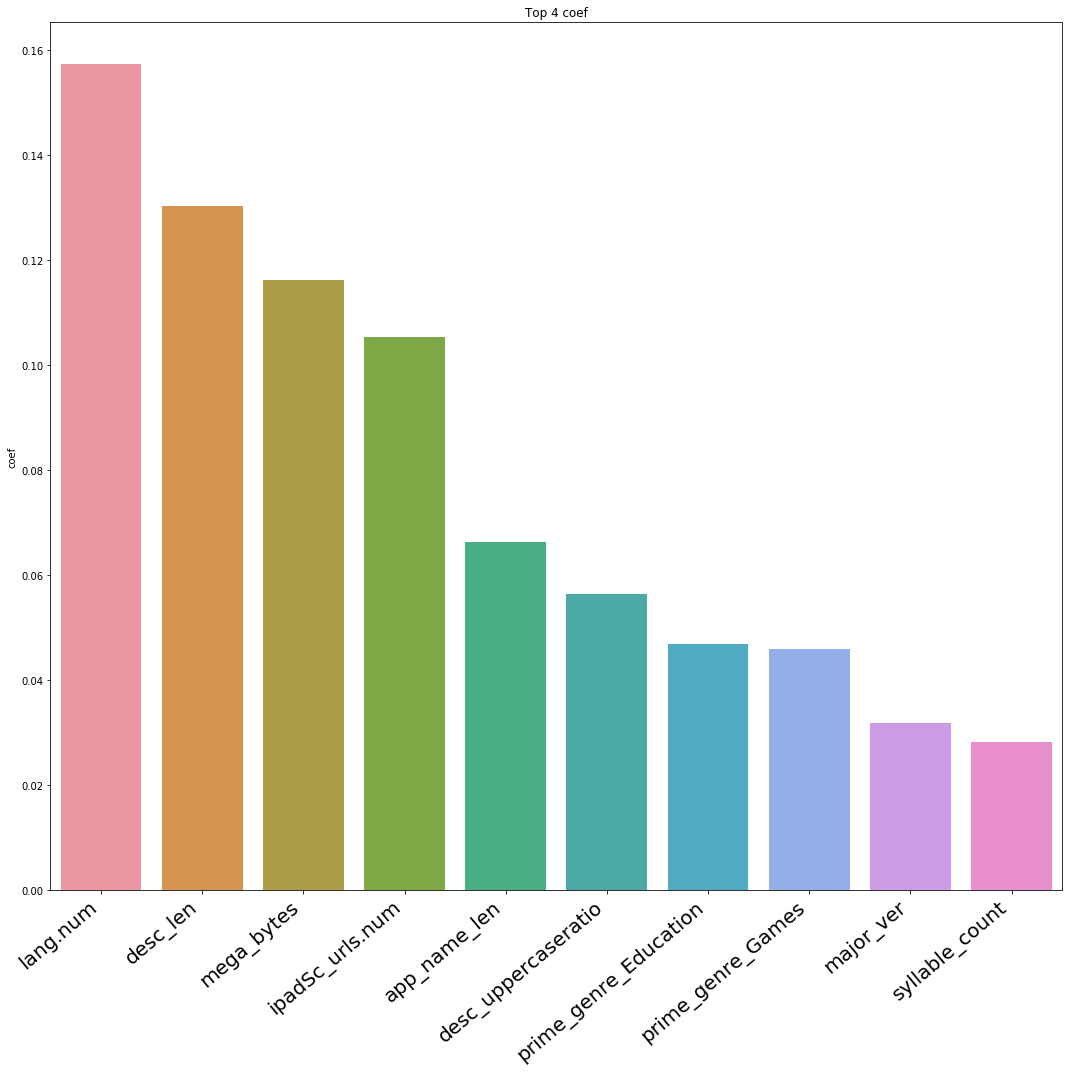

In [24]:
sns.set_palette('Blues_r', n_colors=4, desat=1)
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(x=top_10.index, y=top_10.coef)
ax.set_xticklabels(top_10.index,fontdict={'fontsize': 20}, rotation=40, ha='right')
ax.set_title('Top 10 coef')
plt.tight_layout()
plt.show()

In order for absolute purposes, I will also perform a regression

In [18]:
parametersGrid = {'C': np.logspace(-4,4,20),
                  'penalty':['l1', 'l2']}

lr = LogisticRegression(random_state=1)
grid = GridSearchCV(lr, parametersGrid, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
grid.best_estimator_

lr_best = grid.best_estimator_

print('The best model achieves an accuracy score of {}, with parameters: {}'\
      .format(round(grid.best_score_,3), grid.best_params_))

The best model achieves an accuracy score of 0.6, with parameters: {'C': 0.012742749857031334, 'penalty': 'l1'}


In [39]:
coef_lr = pd.DataFrame(lr_best.coef_[0], 
             X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False).reset_index()

***INCREASE IN APP RATINGS***

**The most important features appear to be screenshots on display, number of language feature, description length and whether the app is part of the gaming genre**

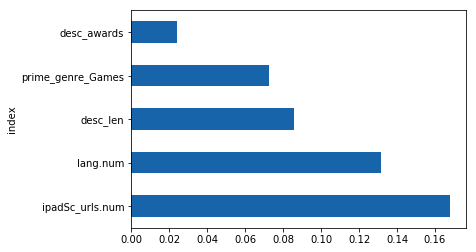

In [277]:
coef_lr.head(5).plot(kind='barh',x='index' ,y='coef', legend=False);

***DECREASE IN APP RATINGS***

**The most important features appear to be genre type (Education, entertainment...) and name length. A longer name has a negative impact on user ratings.**

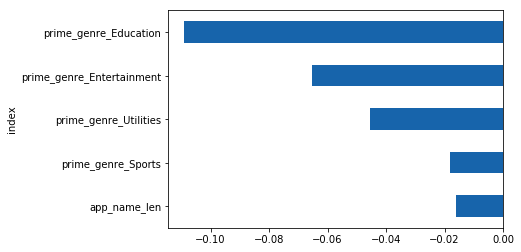

In [46]:
coef_lr.tail(5).plot(kind='barh',x='index' ,y='coef', legend=False);

However, a drawback to this analysis includes that as apps get bigger they get treated more unfairly with higher expectations. 

The score is pretty low and only 10 percent above baseline.

In an attempt to optimise this further I explore recursive feature elimination

In [80]:
selector = RFE(lr_best,step=1)
selector = selector.fit(X_train, y_train)
print(selector.score(X_train, y_train))

0.6016175860638739


In [77]:
selector = RFECV(lr_best, step=1, cv=5)
selector = selector.fit(X_train, y_train)
print(selector.score(X_train, y_train))

0.6018249688925756


This still does not improve the score. 

# Conclusions and recommendations

When running these models, it is far easier to predict ratings and the accuracy is much higher if including past ratings and counts (popularity). When not including the rating and reviews features, the Classifier peforms at 60% Accuracy. 

This shows that **given the Size, Type, Price, Content Rating, language features and Genre of an app, we can predict within 60% certainty if an app will have a 4+ user rating.**

**For Innovation** - Developers should focus in on apps with a category of Sports, Utilities and Entertainment, as there are not many highly rated apps in these categories.

**For Popularity** - Everyone building apps should consider that the Category and Genre of an app may strongly dictate if an app will be popular or not. However, the Size, Type, Price, Content Rating, description language, and name should all be used to most accurately determine if an app will gain maximum installs.